## Setup Environment

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install transformers
! pip install pycaret
! pip install squarify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.7 MB/s eta 0:0

In [3]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import os

# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Set Working Directory
!ln -s "/content/drive/My Drive/CS7643" /content/CS7643
%cd /content/drive/My Drive/CS7643/cs7643-groupproject/


/content/drive/My Drive/CS7643/cs7643-groupproject


## Load Dataset

In [5]:
print(os.getcwd())
data = pd.read_csv('Data/final_fake_news.csv')
data['Target'] = 'True'
data.loc[data['label'] == 0, 'Target'] = 'Fake'
data = data.sample(frac=1).reset_index().drop(columns=['index'])
data['label'] = pd.get_dummies(data.Target)['Fake']
print(data.shape)
data.head()

/content/drive/My Drive/CS7643/cs7643-groupproject
(39409, 3)


,text,label,Target
0,make vietnam inauguration origin red trump hat...,0,True
1,break obama reportedly return columbia univers...,1,Fake
2,damn text surface christie bridgegate scandal ...,1,Fake
3,conservative news punish trump win facebook de...,1,Fake
4,hand eu trump nt back ohio secession juncker b...,0,True


In [ ]:
# True/Fake to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake']

In [ ]:
data.head()

,text,label,Target
0,cheat first picture hillary custom podium deba...,1,Fake
1,trump soninlaw kushner become senior white hou...,0,True
2,trump meet u house republicans thursday tax wh...,0,True
3,bernie sander say moderate progressive tweet b...,1,Fake
4,macron popularity improve poll paris reuters f...,0,True


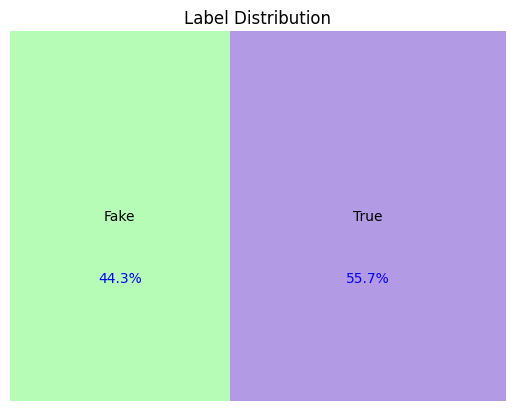

In [ ]:
import matplotlib.pyplot as plt
import squarify

label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]
labels = ['Fake', 'True']
colors = ['#98FB98', '#9370DB']

fig, ax = plt.subplots()
squarify.plot(sizes=label_size, label=labels, color=colors, alpha=0.7, ax=ax)

plt.title('Label Distribution')
plt.axis('off')

for i, rect in enumerate(ax.patches):
    percentage = label_size[i] / sum(label_size) * 100
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_y() + rect.get_height() / 3
    plt.text(x=x, y=y, s=f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='blue')

plt.show()

## Train-test-split

In [6]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [7]:
# Load BERT model and tokenizer
#bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Prepare Input Data

In [8]:
# Get the vocabulary
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)
# Print the size of the vocabulary
print("Vocabulary size: ", len(vocab))

Vocabulary size:  30522


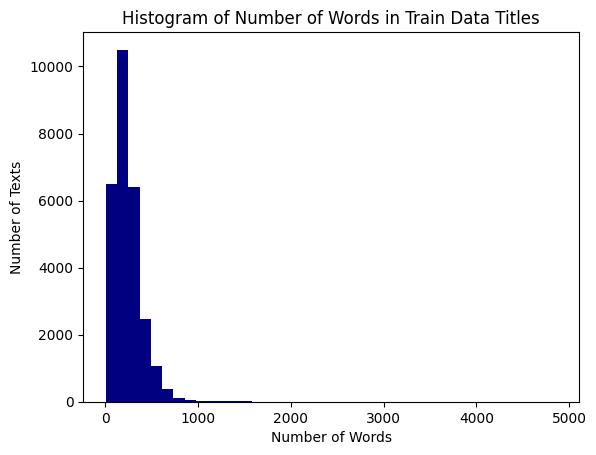

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of words in each title
seq_len = [len(title.split()) for title in train_text]

plt.hist(seq_len, bins=40, color='navy')

plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')
plt.title('Histogram of Number of Words in Train Data Titles')

# Show the plot
plt.show()

In [9]:
#Set hyperparameters
vocab_size = len(vocab)
MAX_LENGHT = 15
batch_size = 32
PAD_IDX = 0
output_size = 1

#LSTM param
embedding_dim = 64  # Size of the word embeddings
hidden_dim = 128  # Size of the hidden state in the LSTM
num_layers = 2  # Number of LSTM layers
dropout = 0.3  # Dropout rate


learning_rate = 1e-5
l2norm=0.1
EPOCHS = 20

model_path = 'model_LSTM.pth'

In [10]:
# Set max title length

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
print(train_text[0:5])
print(tokens_train[0:10])

31410    judge jeanine slam hillary epic open statement...
34537    greek guerrilla group assassin give jail leave...
34096    trump hate mexican magazine unmask cover image...
14010    lindsey graham get war tingly talk donald trum...
21691    watch jake tapper rip michael flynn hypocrisy ...
Name: text, dtype: object
[Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_

In [11]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [ ]:
with open('output.txt', "w+") as file:
    file.write(str(tokens_train['input_ids']))

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

### Define Model Architecture

In [13]:
import numpy as np
import torch
from torch import nn
import random

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True).to(device)
        self.fc1 = nn.Linear(hidden_dim, 64).to(device)
        self.fc2 = nn.Linear(64, 1).to(device)
        self.dropout1 = nn.Dropout(dropout).to(device)
        self.relu =  nn.ReLU().to(device)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_time_step_out = lstm_out[:, -1, :]
        final_time_step_out = self.batchnorm1(final_time_step_out)
        fc1_out = self.fc1(final_time_step_out)
        fc1_out = self.relu(fc1_out)
        fc1_out = self.dropout1(fc1_out)
        fc2_out = self.fc2(fc1_out).squeeze(-1)
        return fc2_out


### Define Train & Evaluate Function

In [14]:
from tqdm import tqdm_notebook

def train(model, dataloader, optimizer, criterion, scheduler=None, device='cpu'):
    model.train()

    # Record total loss
    total_loss = 0.

    # Get the progress bar for later modification
    progress_bar = tqdm_notebook(dataloader, ascii=True)

    # Mini-batch training
    for batch_idx, data in enumerate(progress_bar):
        source = data[0].to(device)
        mask = data[1].to(device)
        target = data[2].unsqueeze(1).to(device)
        translation = model(source)

        optimizer.zero_grad()
        translation = translation.unsqueeze(1)
        target = target.float()
        loss = criterion(translation, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_description_str(
            "Batch: %d, Loss: %.4f" % ((batch_idx + 1), loss.item()))

    return total_loss, total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device='cpu'):
    # Set the model to eval mode to avoid weights update
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm_notebook(dataloader, ascii=True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            translation = model(source)
            translation = translation.unsqueeze(1)
            target = target.float()
            loss = criterion(translation, target)
            total_loss += loss.item()
            progress_bar.set_description_str(
                "Batch: %d, Loss: %.4f" % ((batch_idx + 1), loss.item()))

    avg_loss = total_loss / len(dataloader)
    return total_loss, avg_loss

def find_accuracy(model, dataloader, device):
    # Set the model to eval mode to avoid weights update
    model.eval()
    correct_pred = 0
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm_notebook(dataloader, ascii=True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            translation = model(source)
            translation = translation.unsqueeze(1)
            pred = (translation > 0).int()
            target = target.float()
            correct_items = ((pred == target).int()).sum().item()
            correct_pred += correct_items
            progress_bar.set_description_str(
                "Batch: %d, Correct items: %.4f" % ((batch_idx + 1), correct_items))
    accuracy = correct_pred / (len(dataloader)*batch_size)
    return accuracy

DEBUG: device:cuda
-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.6748. Validation Loss: 0.6315. 
Training Perplexity: 1.9636. Validation Perplexity: 1.8804. 
Training Acc: 0.7310. Validation Acc: 0.7262. 
Saved model
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.5958. Validation Loss: 0.5514. 
Training Perplexity: 1.8145. Validation Perplexity: 1.7356. 
Training Acc: 0.8086. Validation Acc: 0.8100. 
Saved model
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.5194. Validation Loss: 0.4830. 
Training Perplexity: 1.6810. Validation Perplexity: 1.6209. 
Training Acc: 0.8234. Validation Acc: 0.8262. 
Saved model
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.4627. Validation Loss: 0.4294. 
Training Perplexity: 1.5883. Validation Perplexity: 1.5363. 
Training Acc: 0.8343. Validation Acc: 0.8383. 
Saved model
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.4288. Validation Loss: 0.4184. 
Training Perplexity: 1.5354. Validation Perplexity: 1.5196. 
Training Acc: 0.8330. Validation Acc: 0.8355. 
Saved model
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.4131. Validation Loss: 0.3977. 
Training Perplexity: 1.5114. Validation Perplexity: 1.4884. 
Training Acc: 0.8373. Validation Acc: 0.8377. 
Saved model
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.4017. Validation Loss: 0.3828. 
Training Perplexity: 1.4944. Validation Perplexity: 1.4663. 
Training Acc: 0.8427. Validation Acc: 0.8454. 
Saved model
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3971. Validation Loss: 0.3749. 
Training Perplexity: 1.4875. Validation Perplexity: 1.4549. 
Training Acc: 0.8436. Validation Acc: 0.8463. 
Saved model
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3920. Validation Loss: 0.3760. 
Training Perplexity: 1.4799. Validation Perplexity: 1.4564. 
Training Acc: 0.8433. Validation Acc: 0.8466. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3902. Validation Loss: 0.3781. 
Training Perplexity: 1.4773. Validation Perplexity: 1.4595. 
Training Acc: 0.8441. Validation Acc: 0.8465. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3875. Validation Loss: 0.3678. 
Training Perplexity: 1.4732. Validation Perplexity: 1.4445. 
Training Acc: 0.8462. Validation Acc: 0.8480. 
Saved model
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3844. Validation Loss: 0.3769. 
Training Perplexity: 1.4688. Validation Perplexity: 1.4578. 
Training Acc: 0.8431. Validation Acc: 0.8443. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3813. Validation Loss: 0.3790. 
Training Perplexity: 1.4641. Validation Perplexity: 1.4609. 
Training Acc: 0.8457. Validation Acc: 0.8473. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3804. Validation Loss: 0.3651. 
Training Perplexity: 1.4628. Validation Perplexity: 1.4407. 
Training Acc: 0.8463. Validation Acc: 0.8463. 
Saved model
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

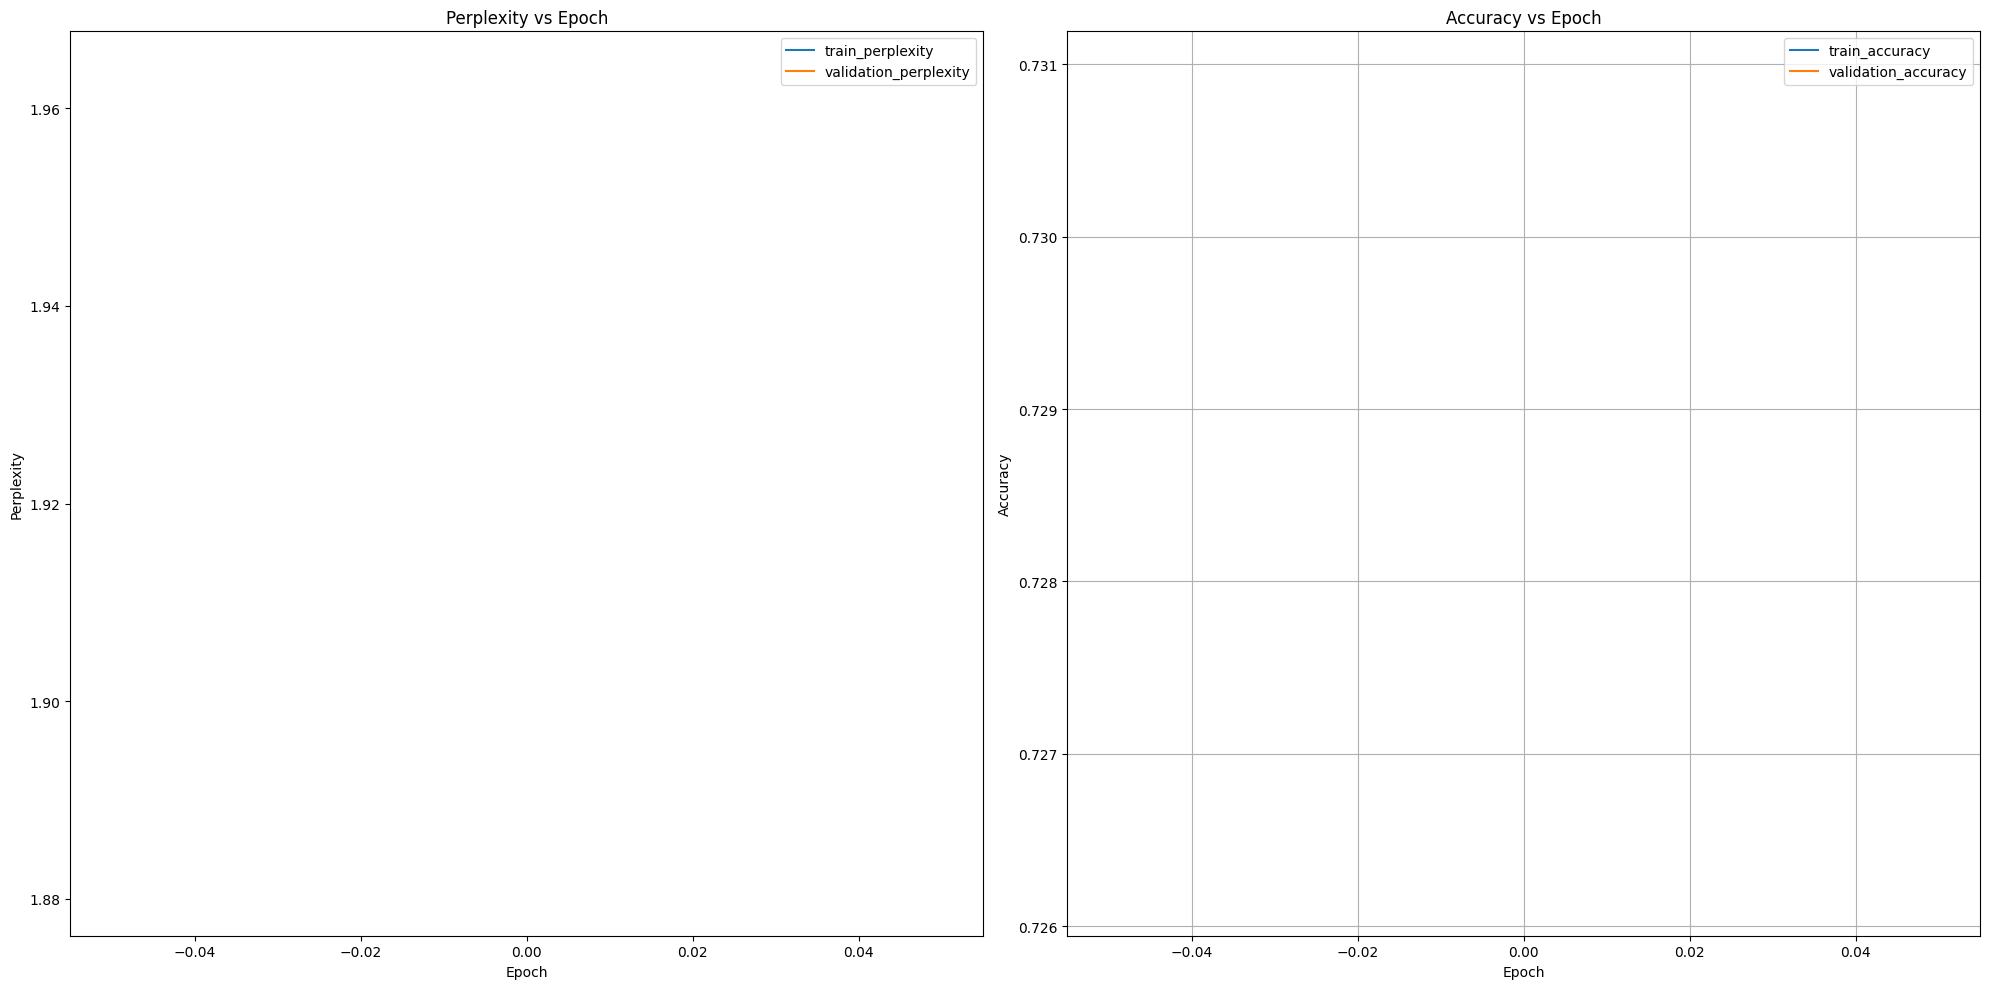

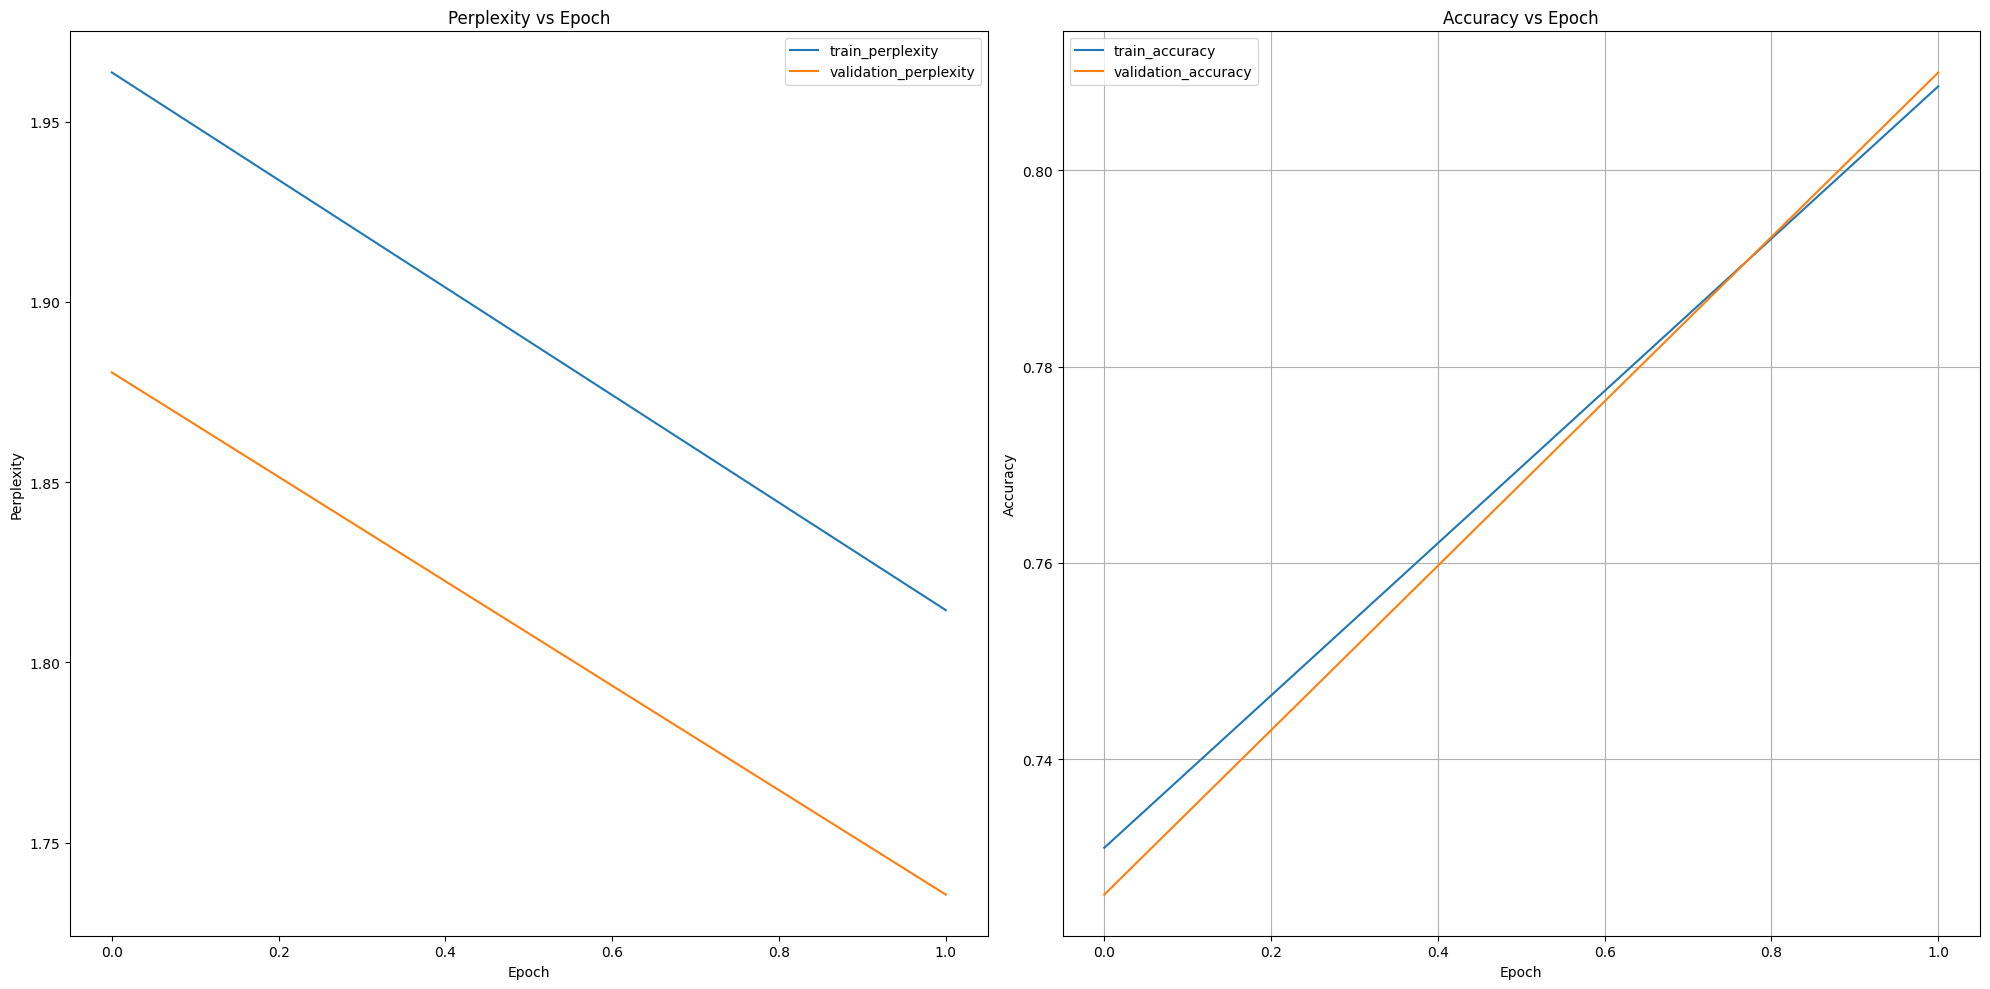

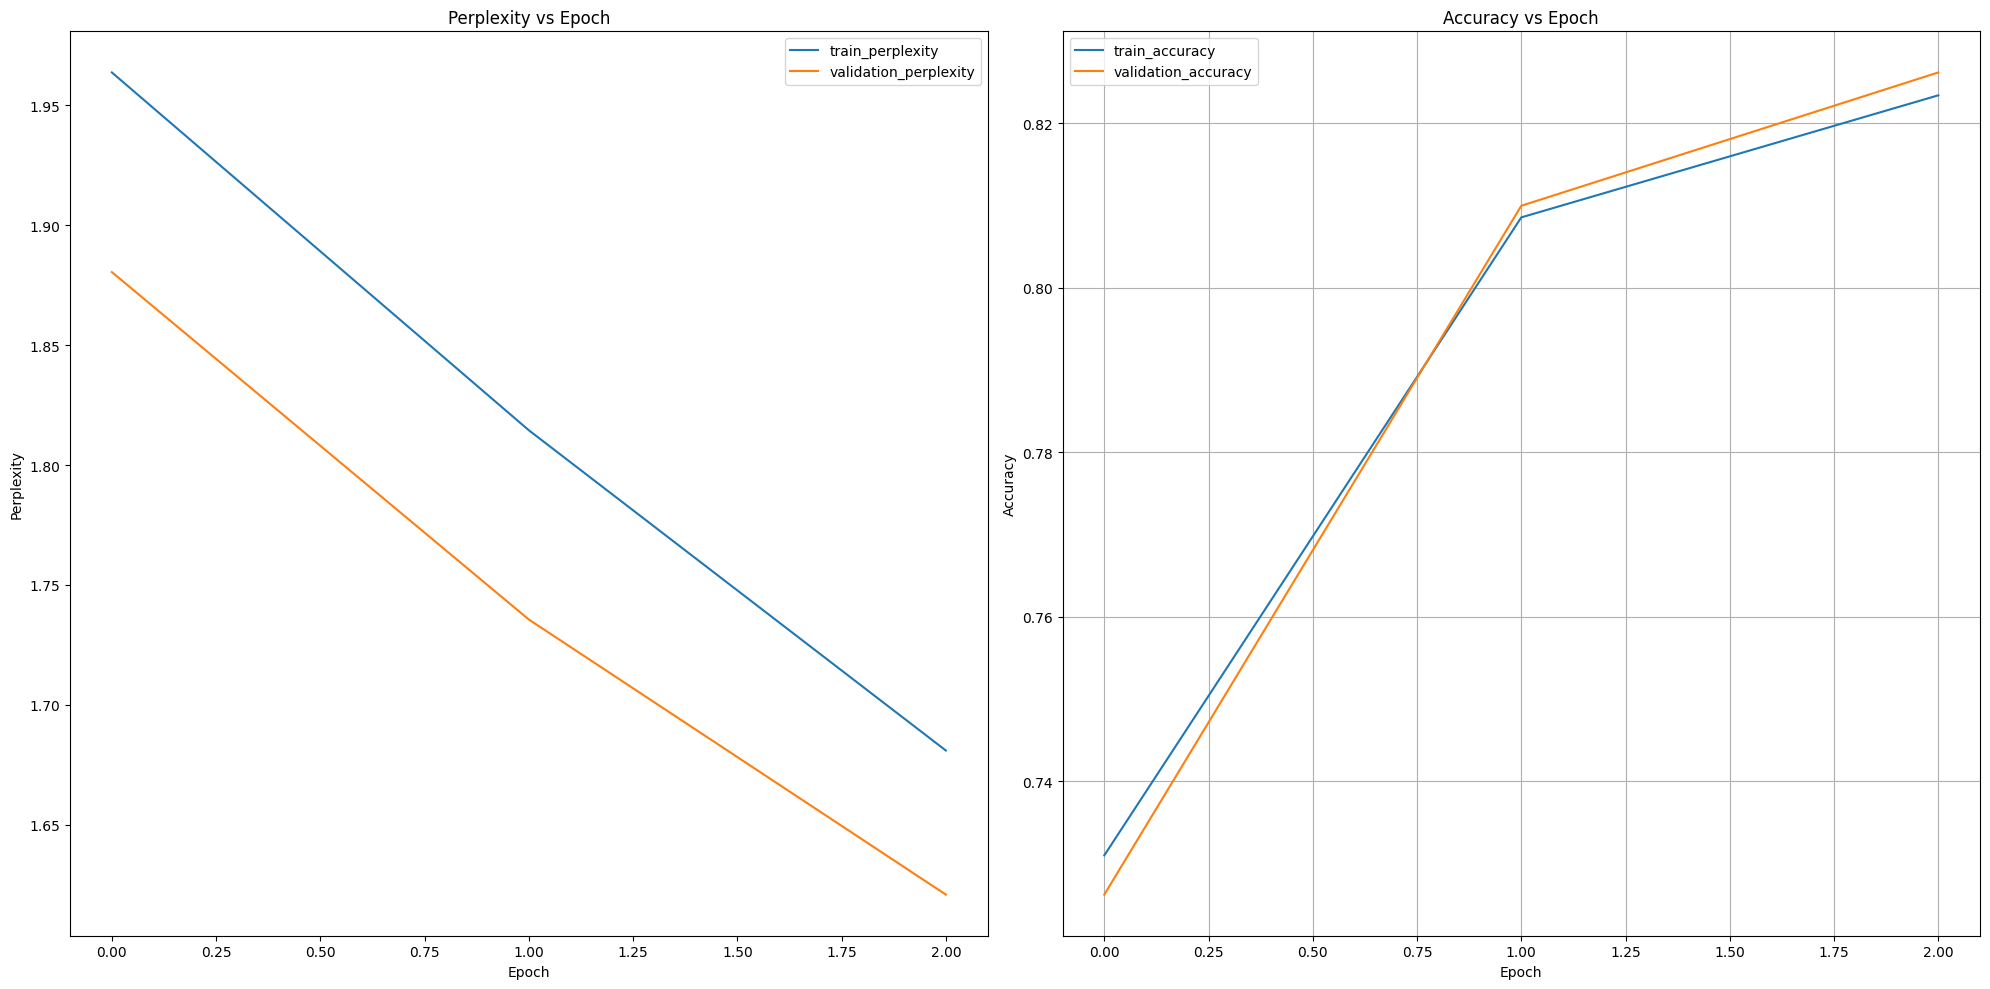

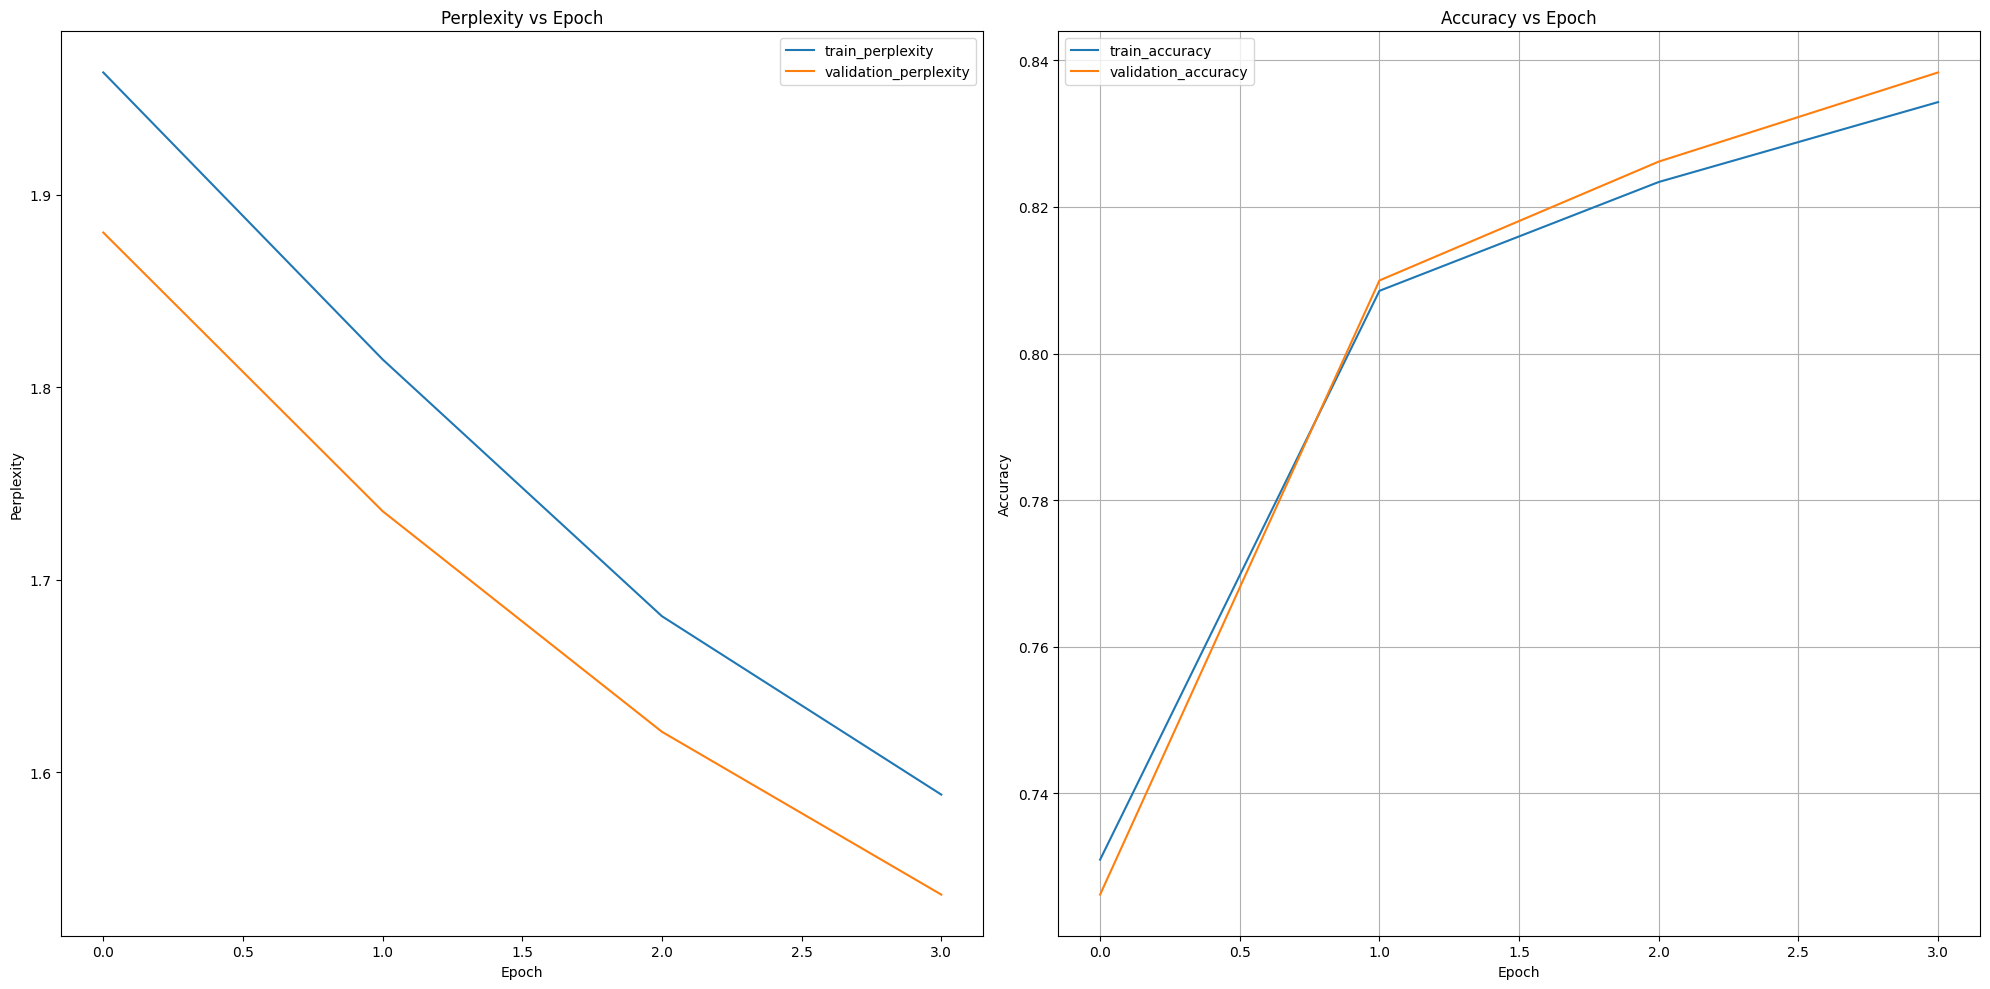

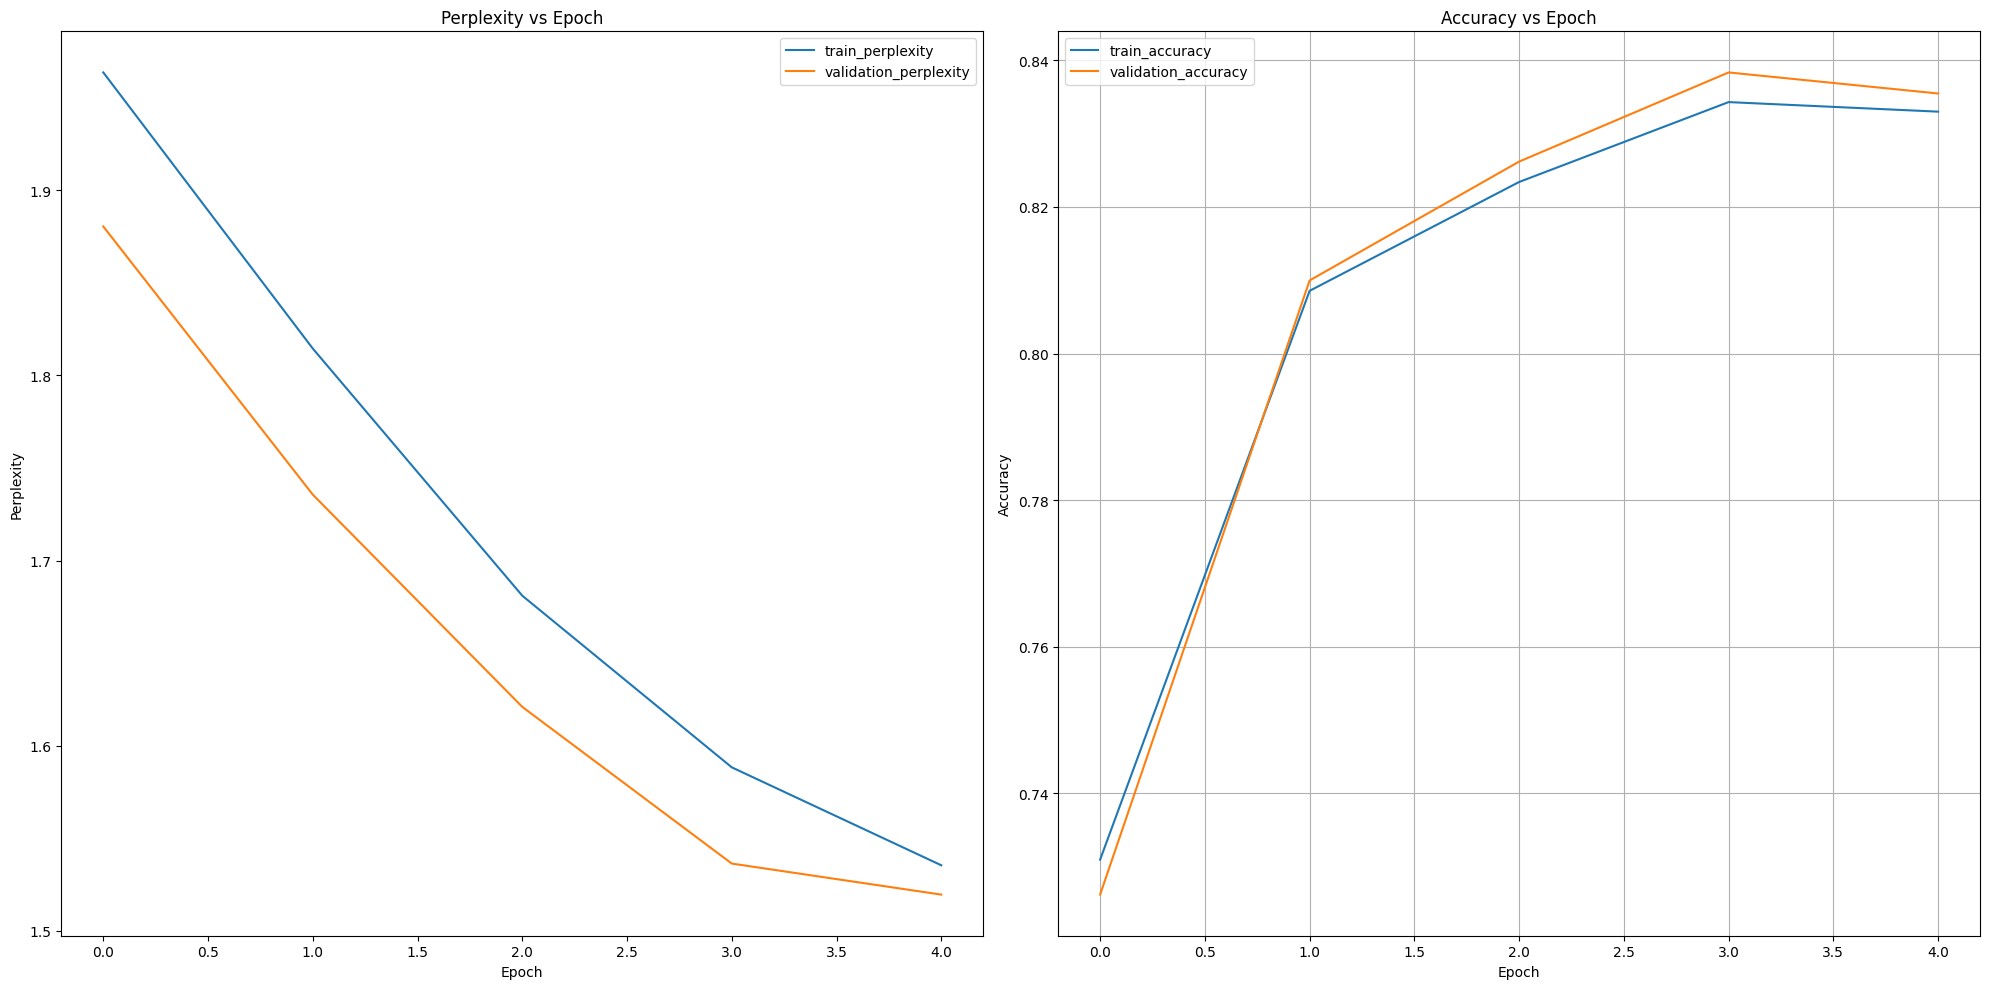

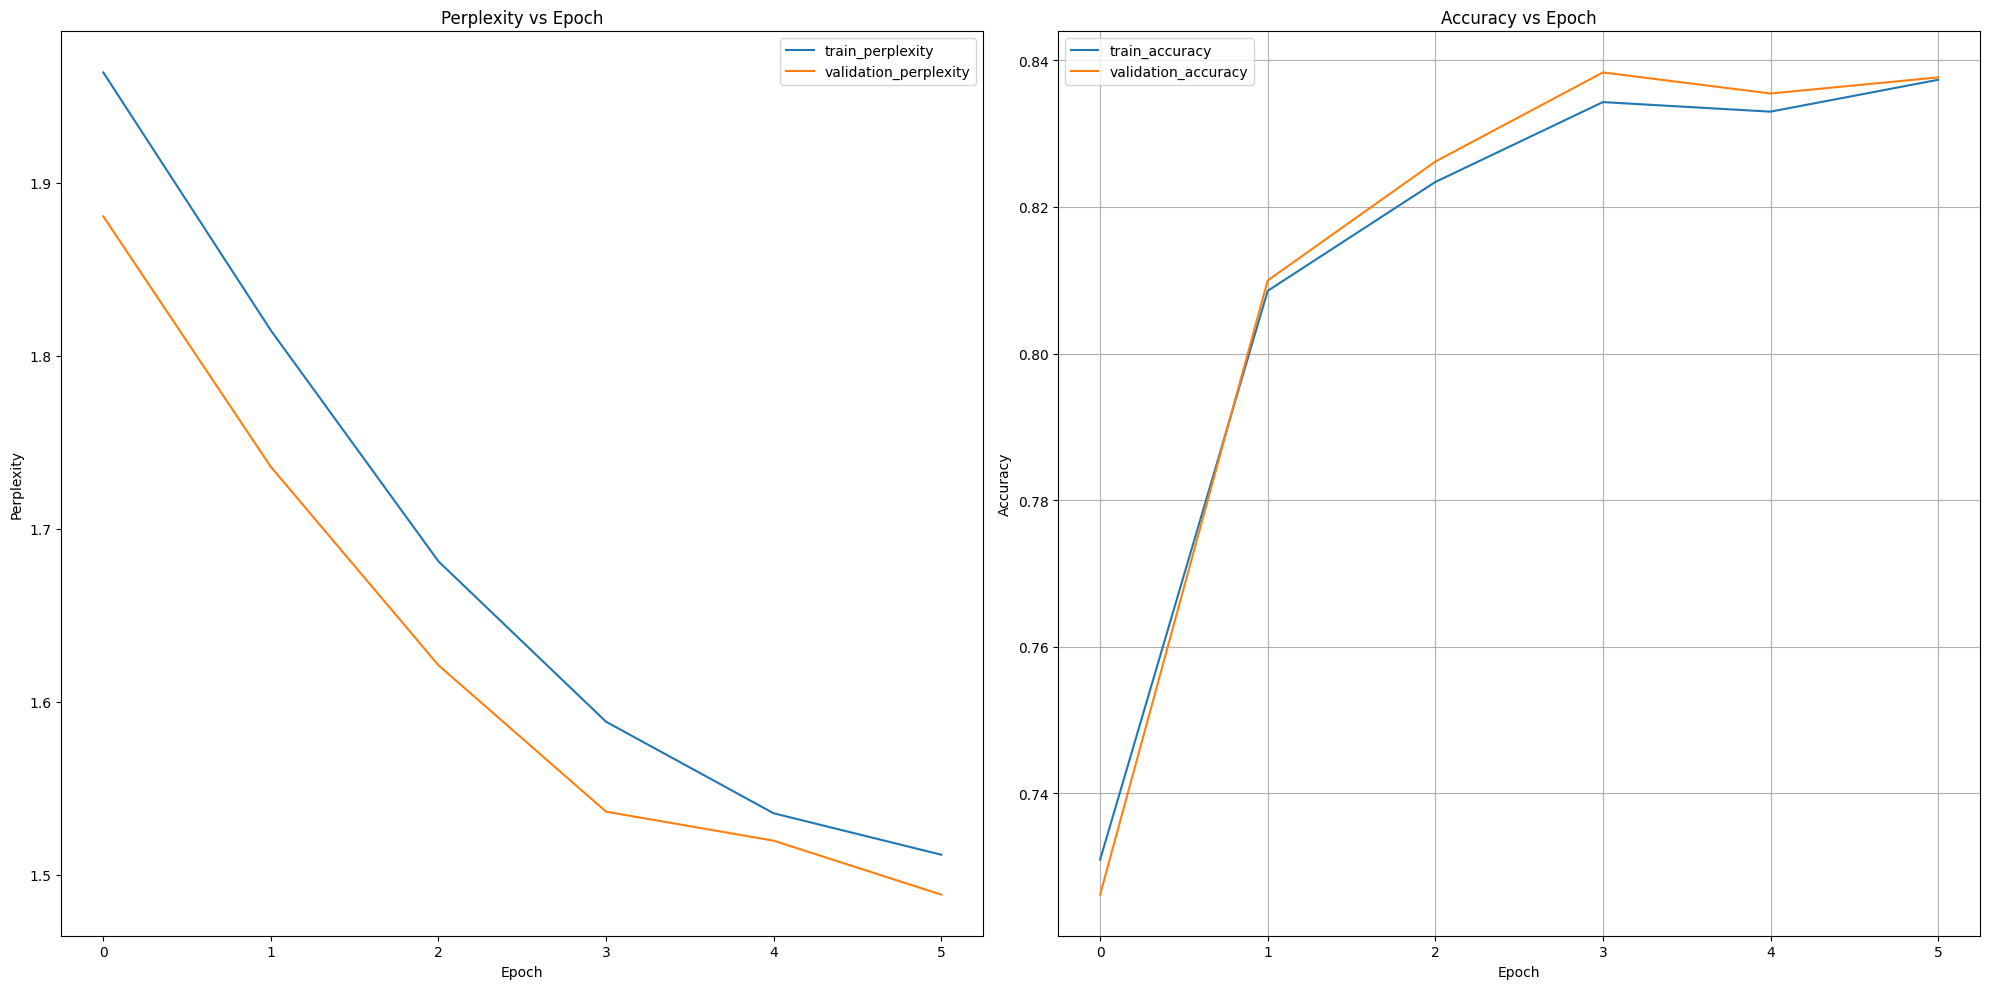

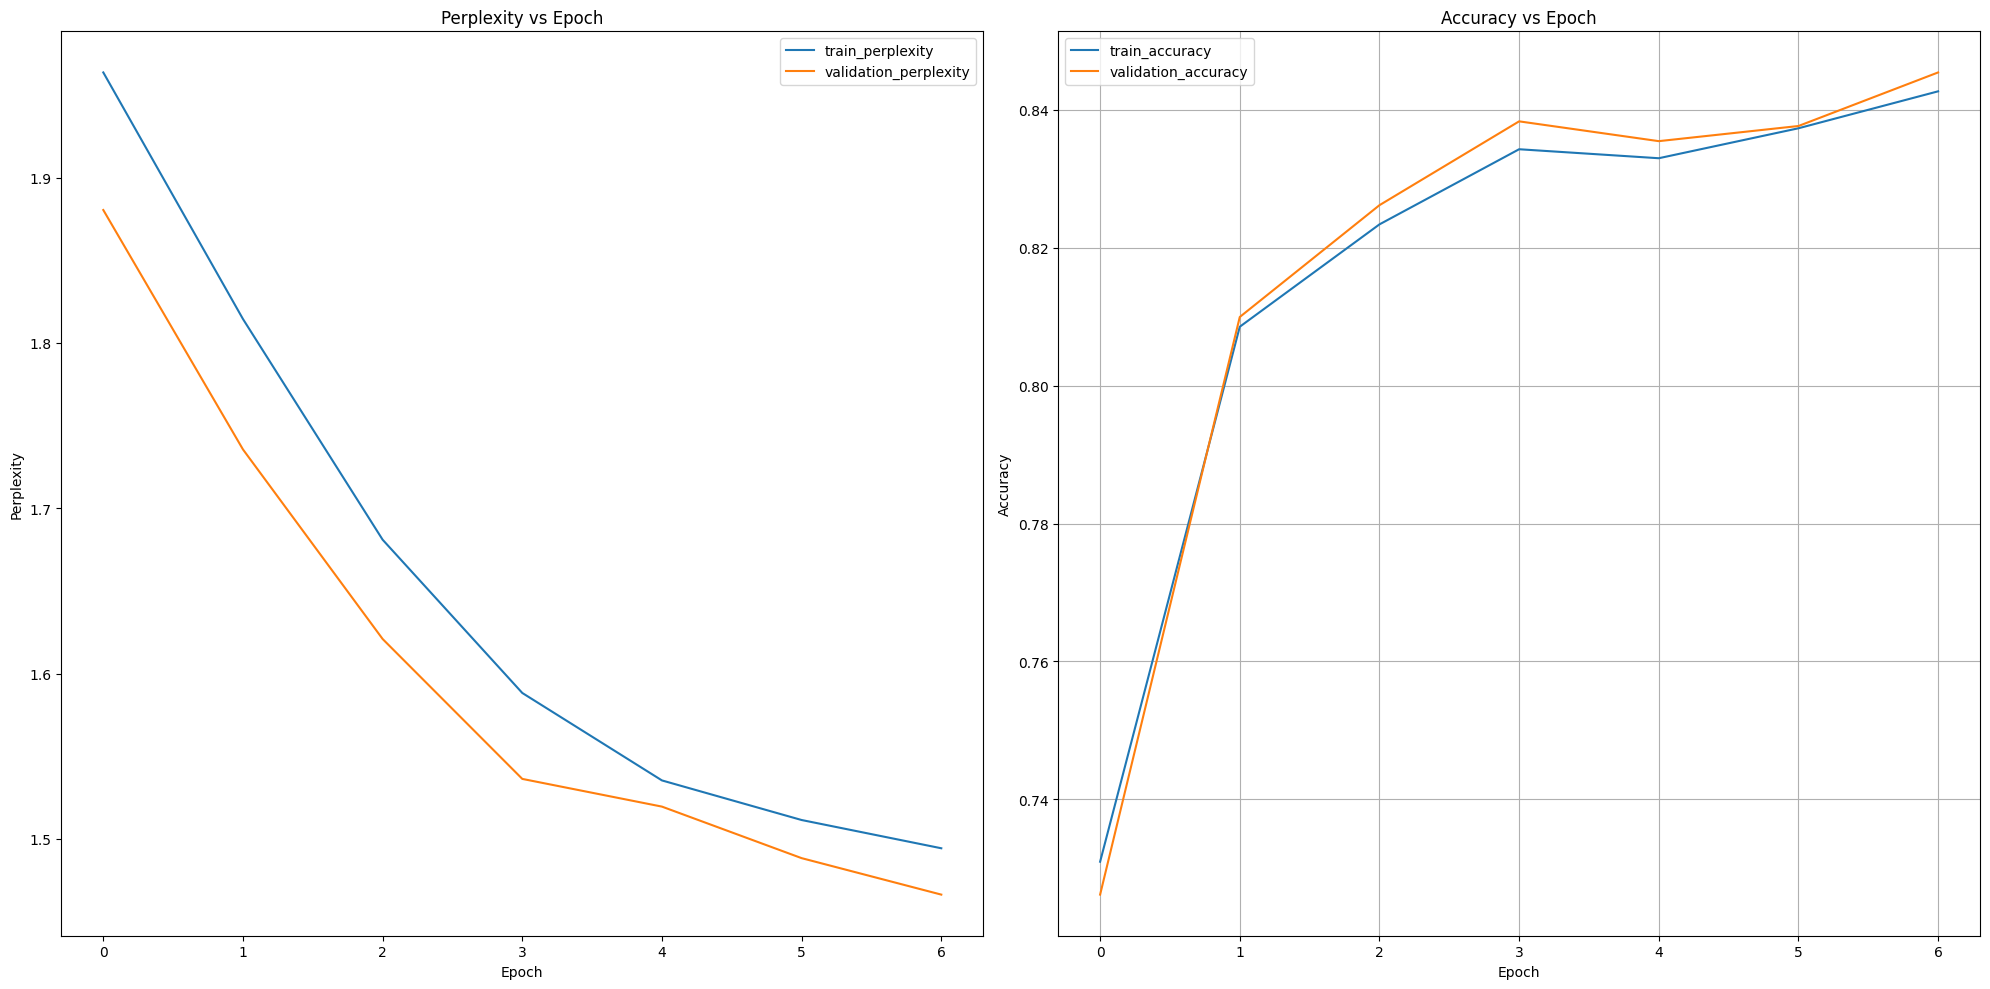

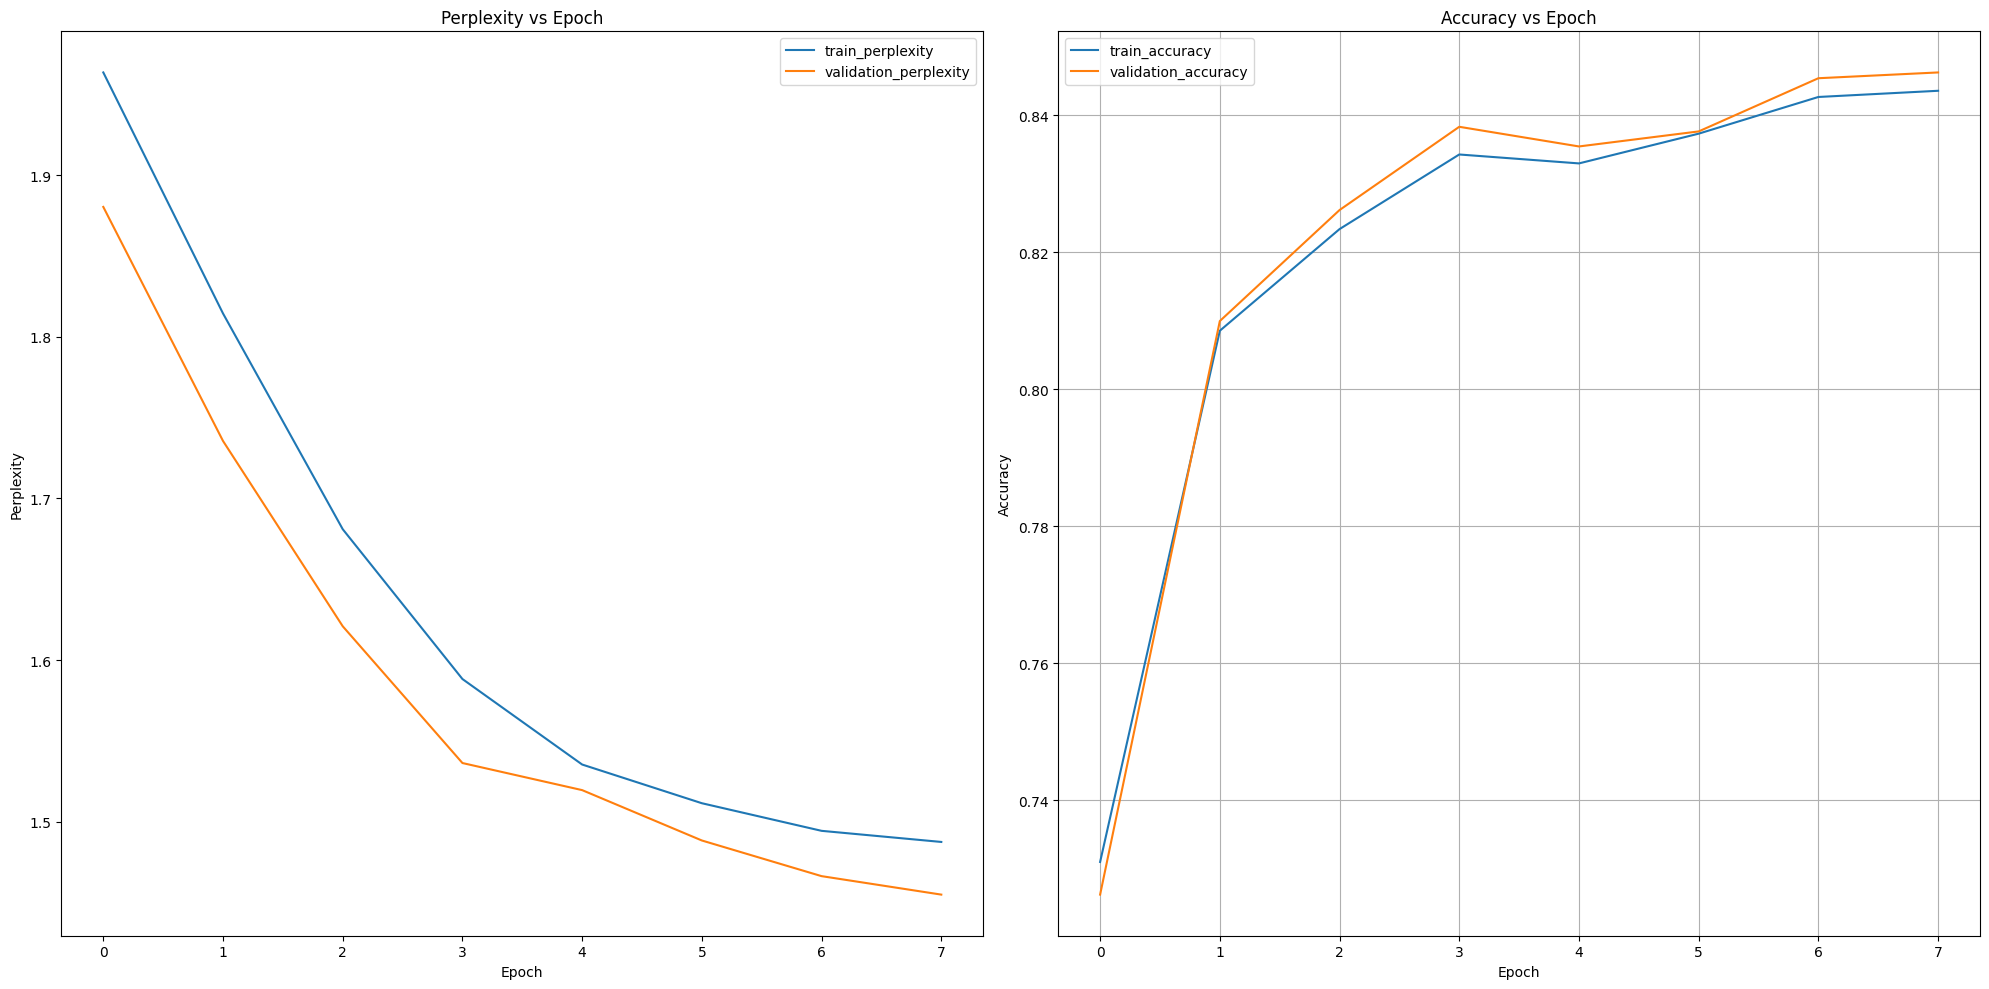

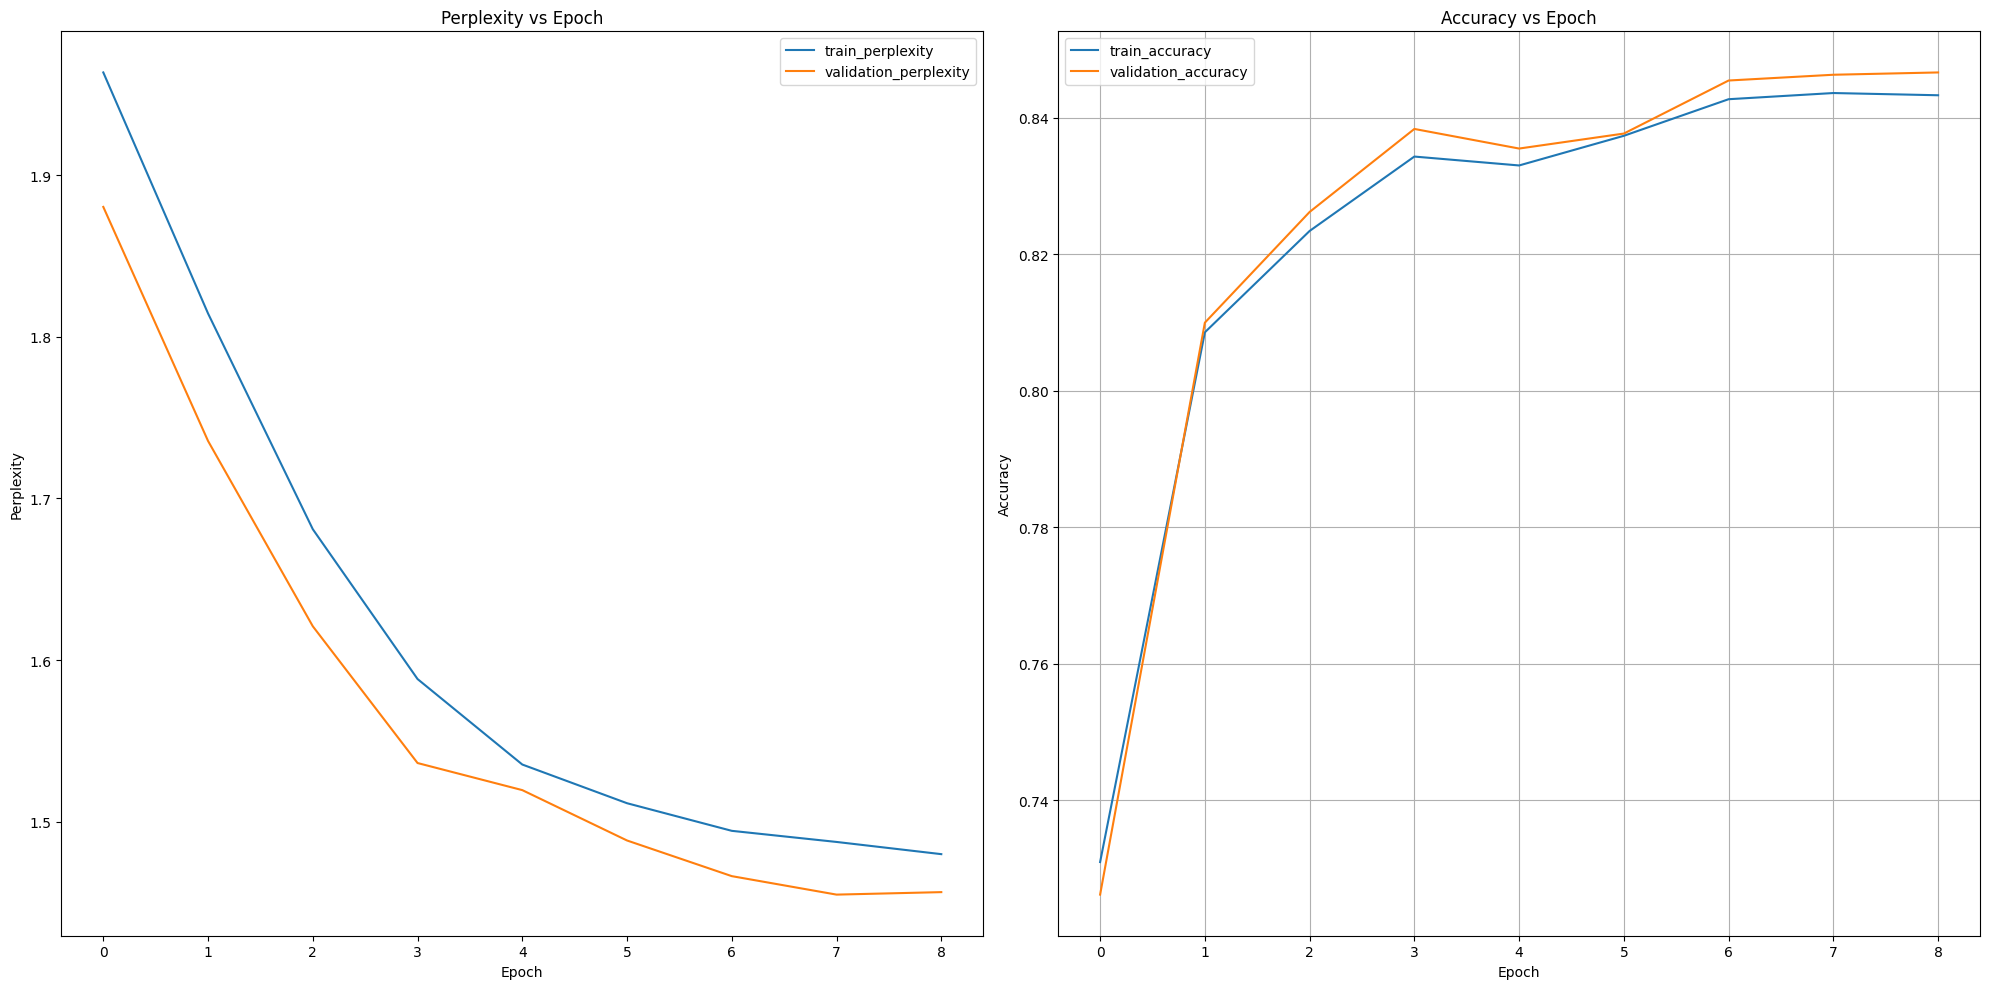

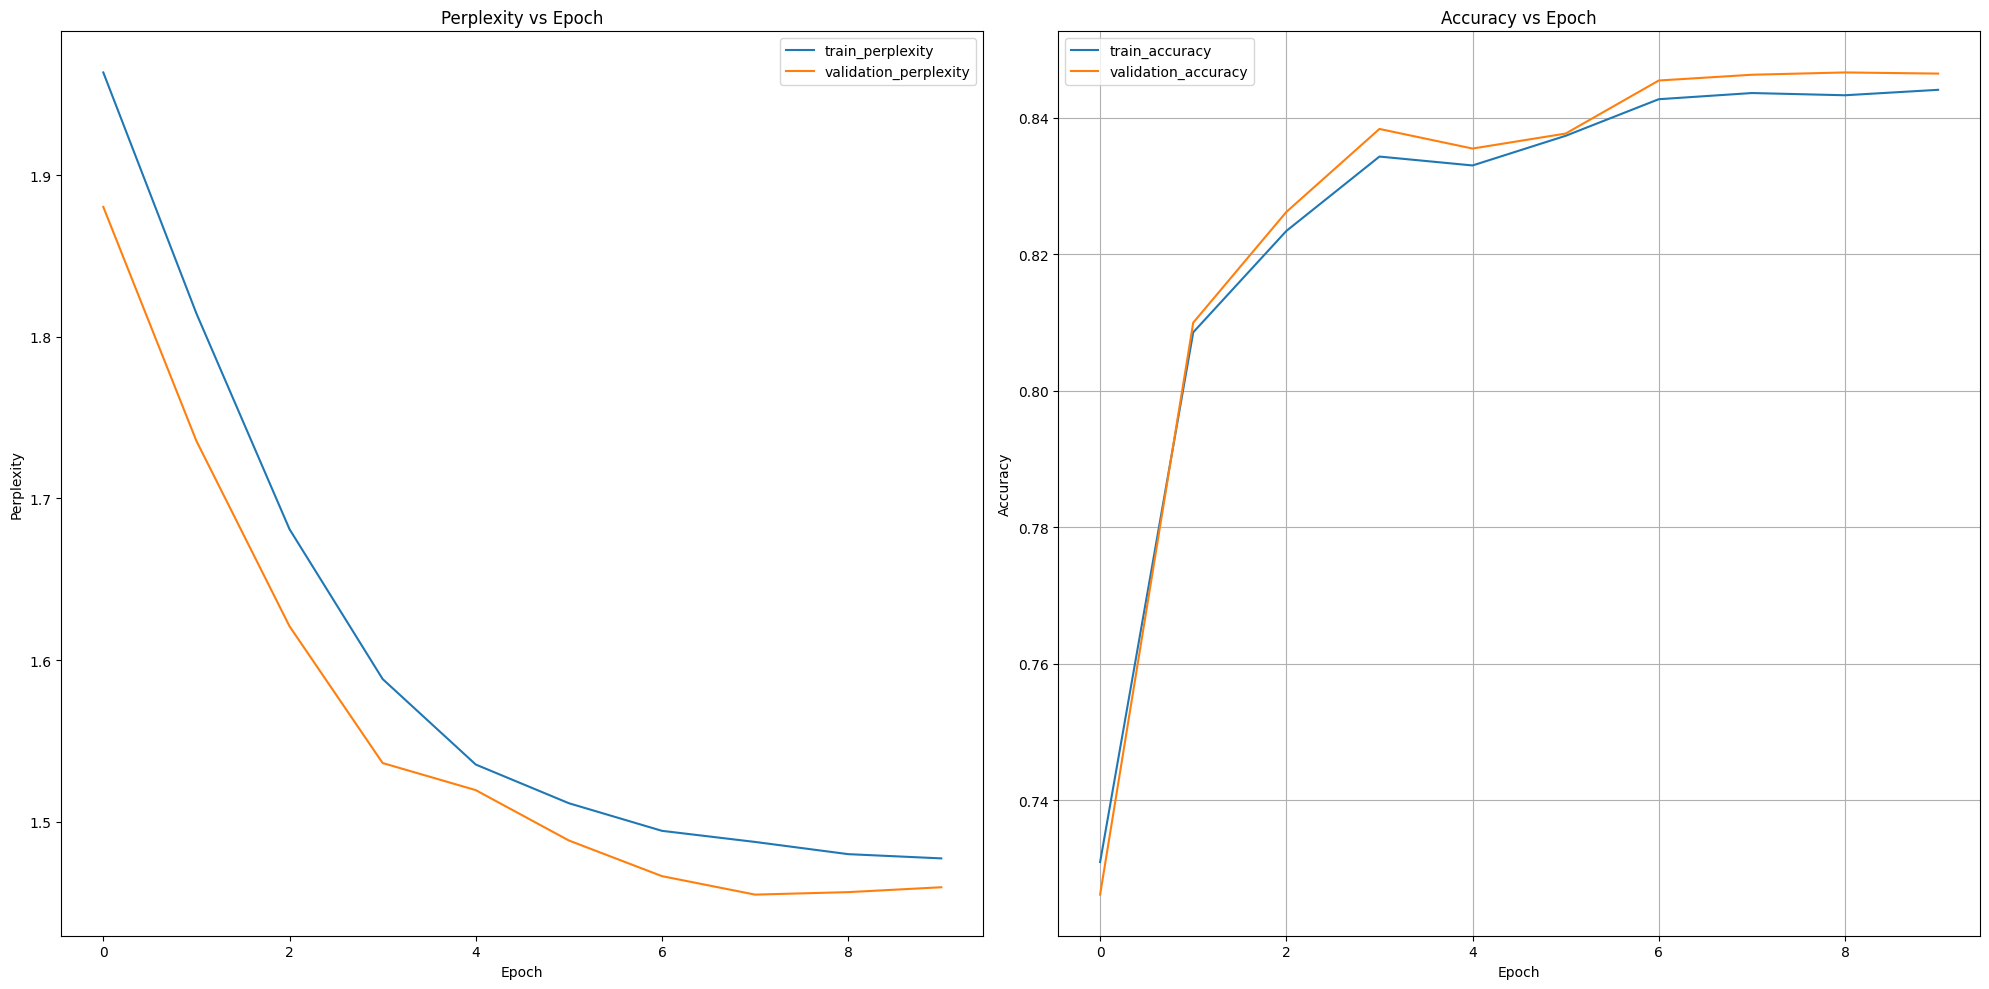

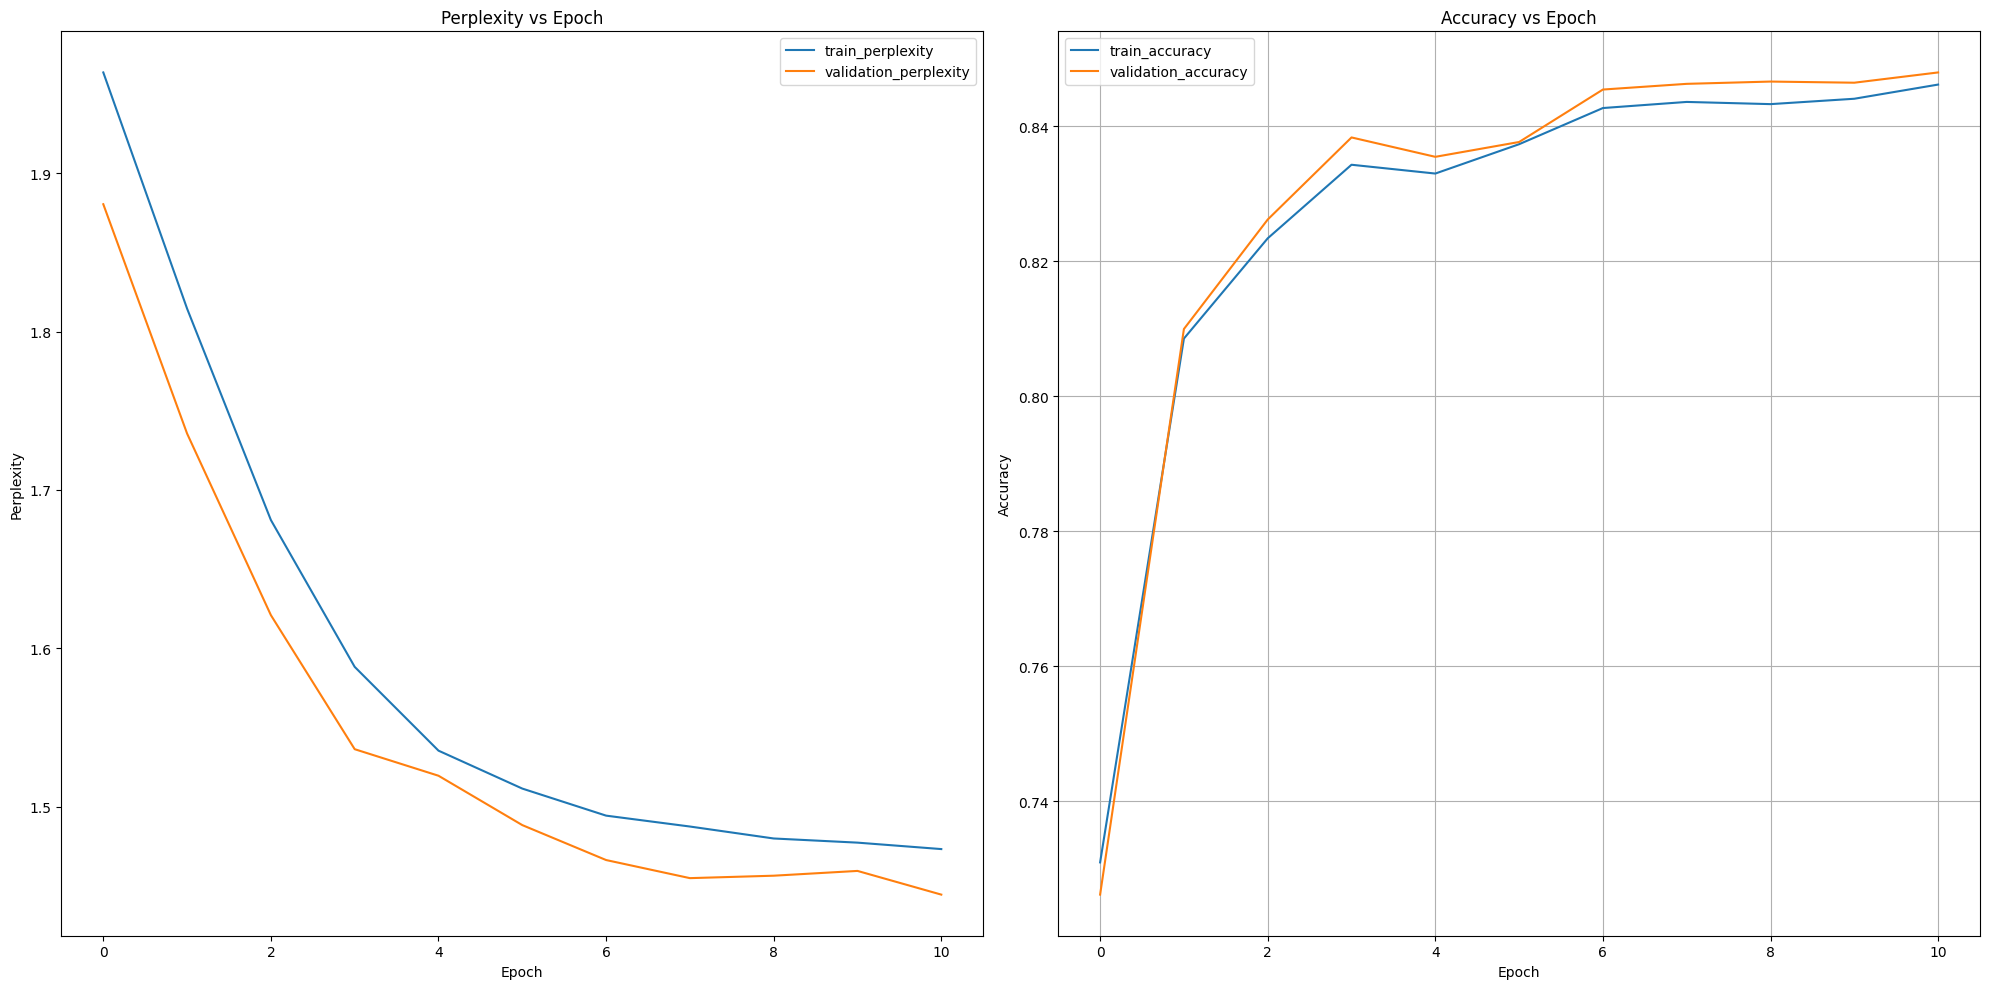

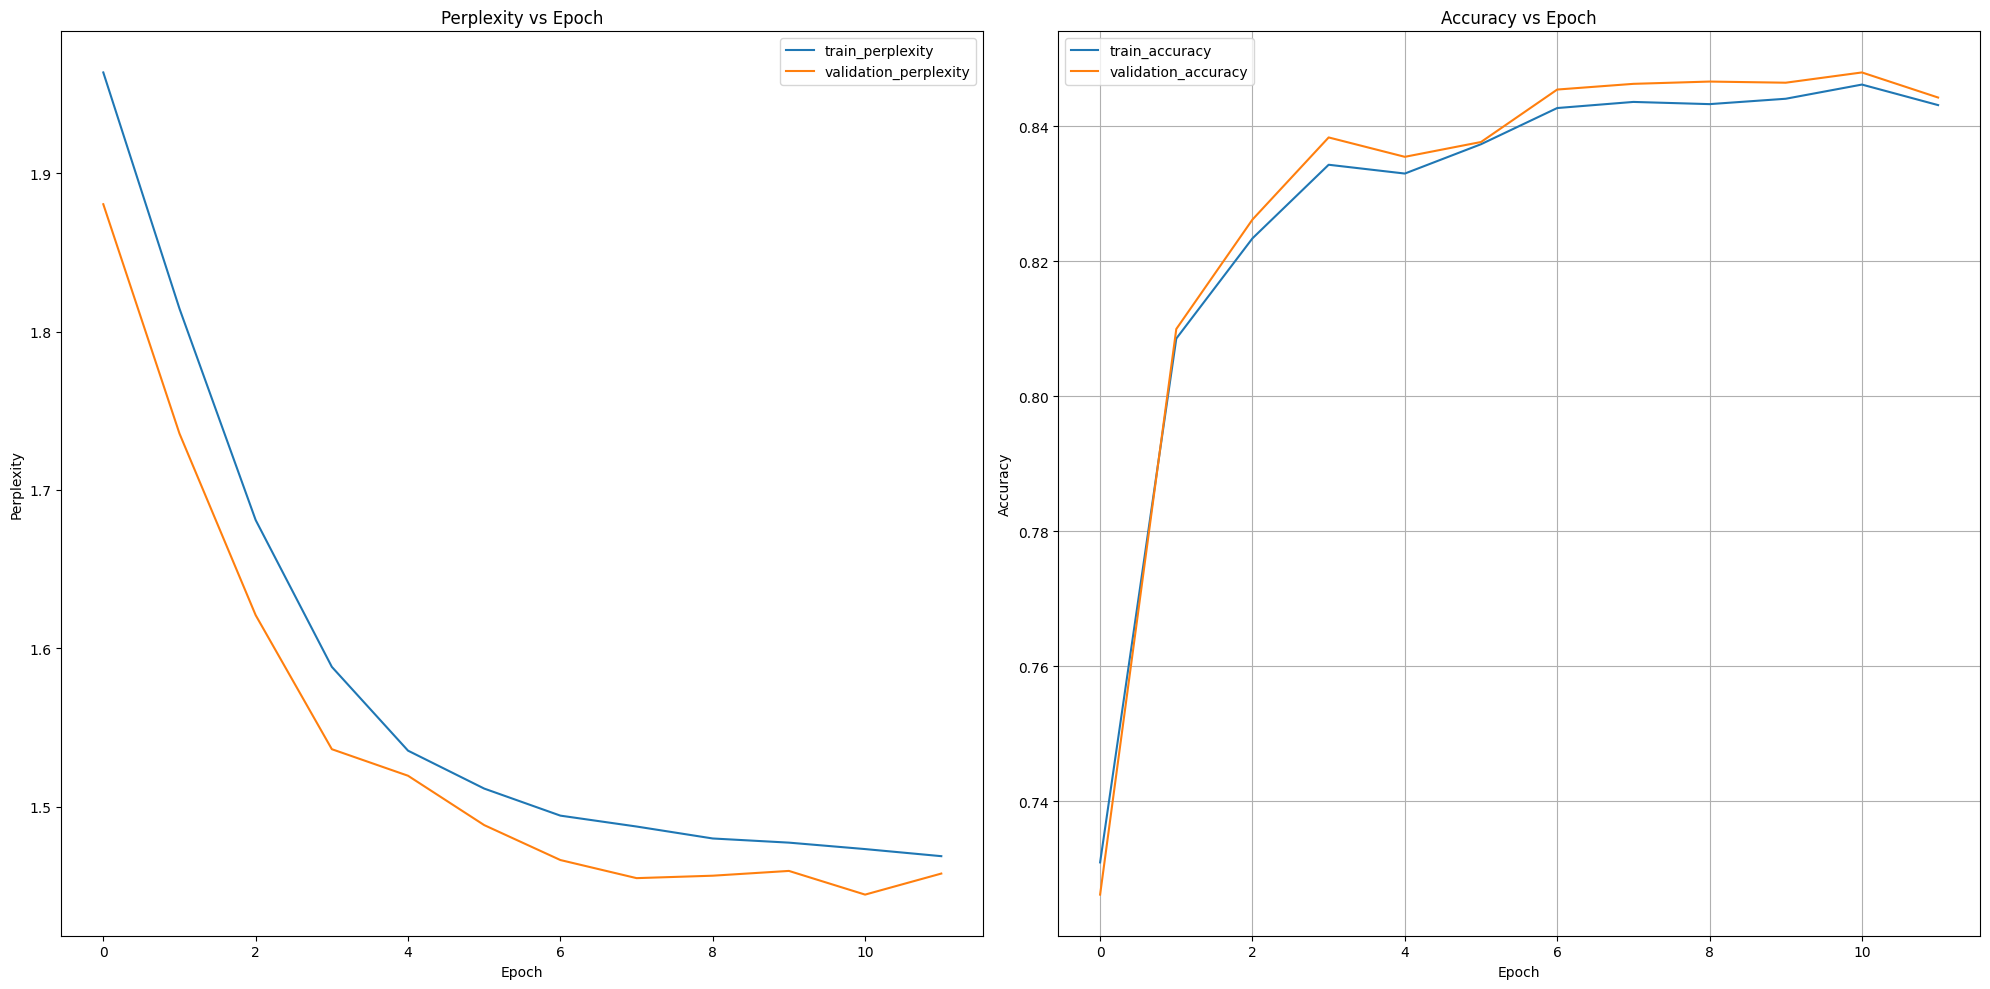

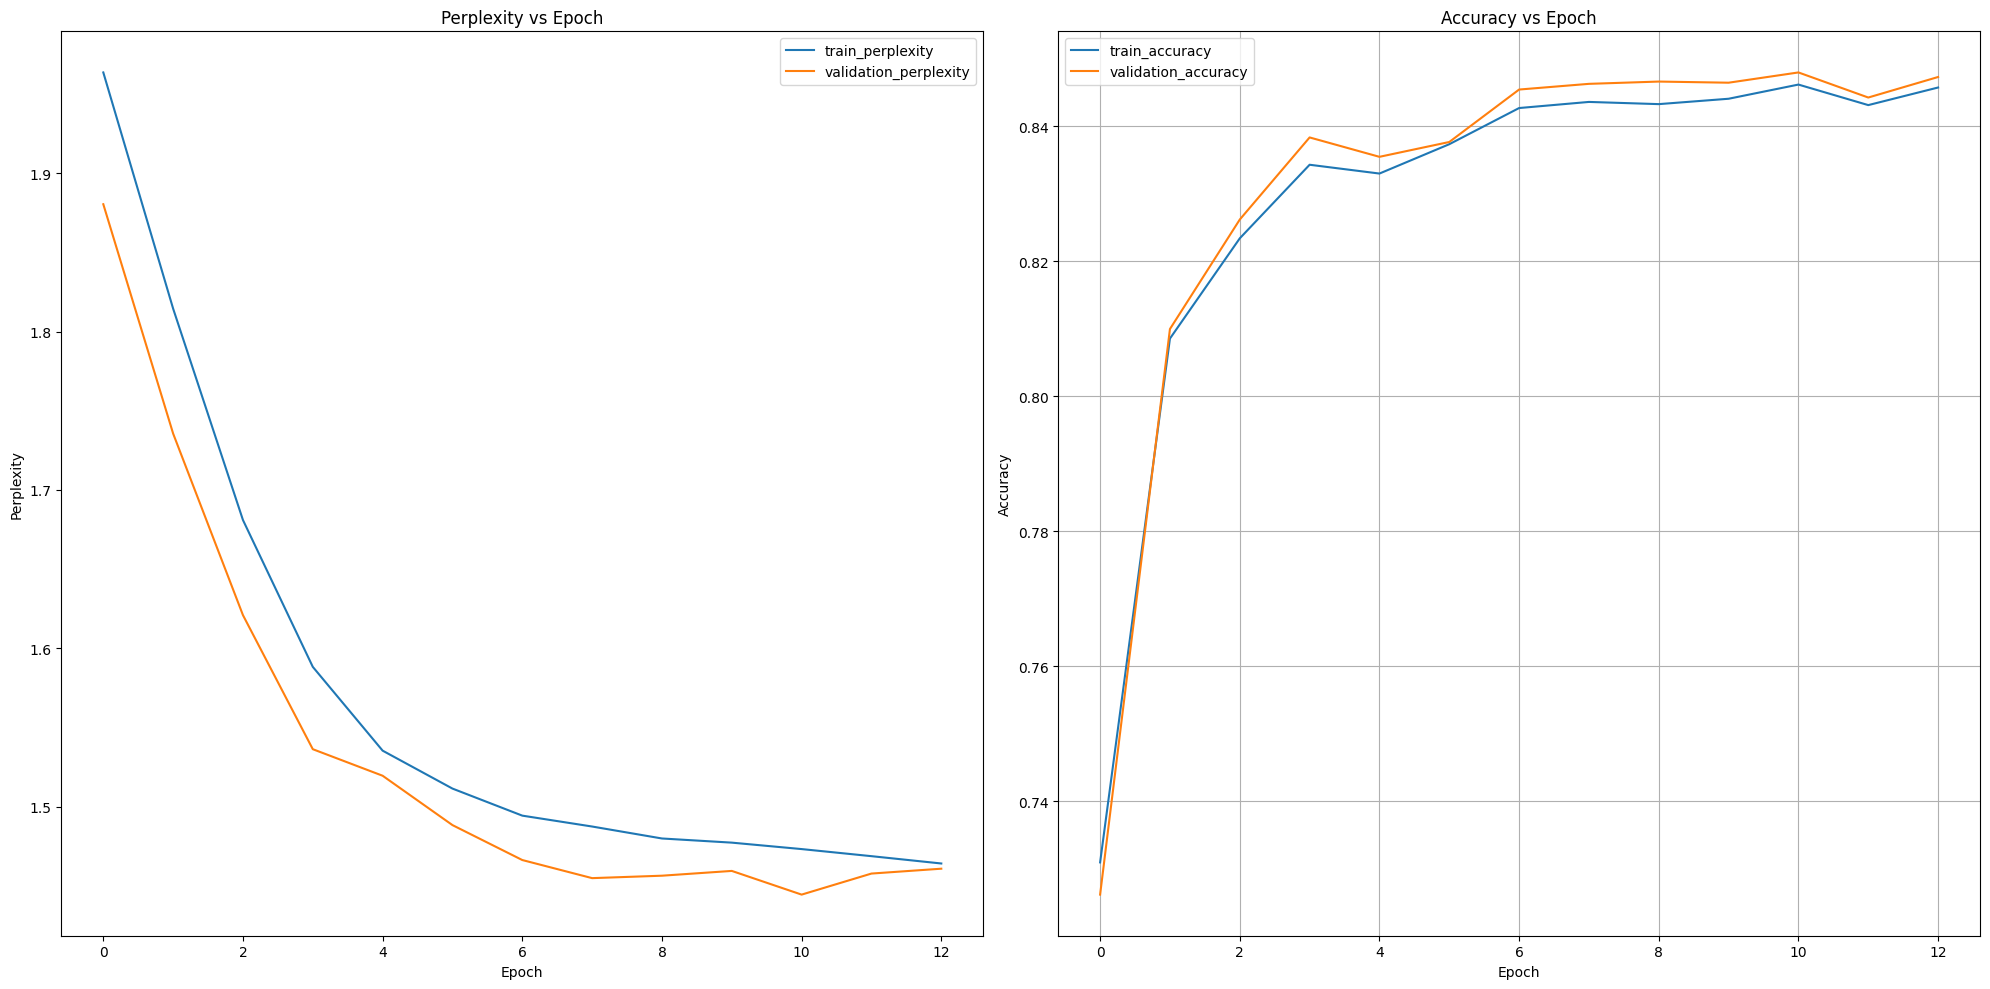

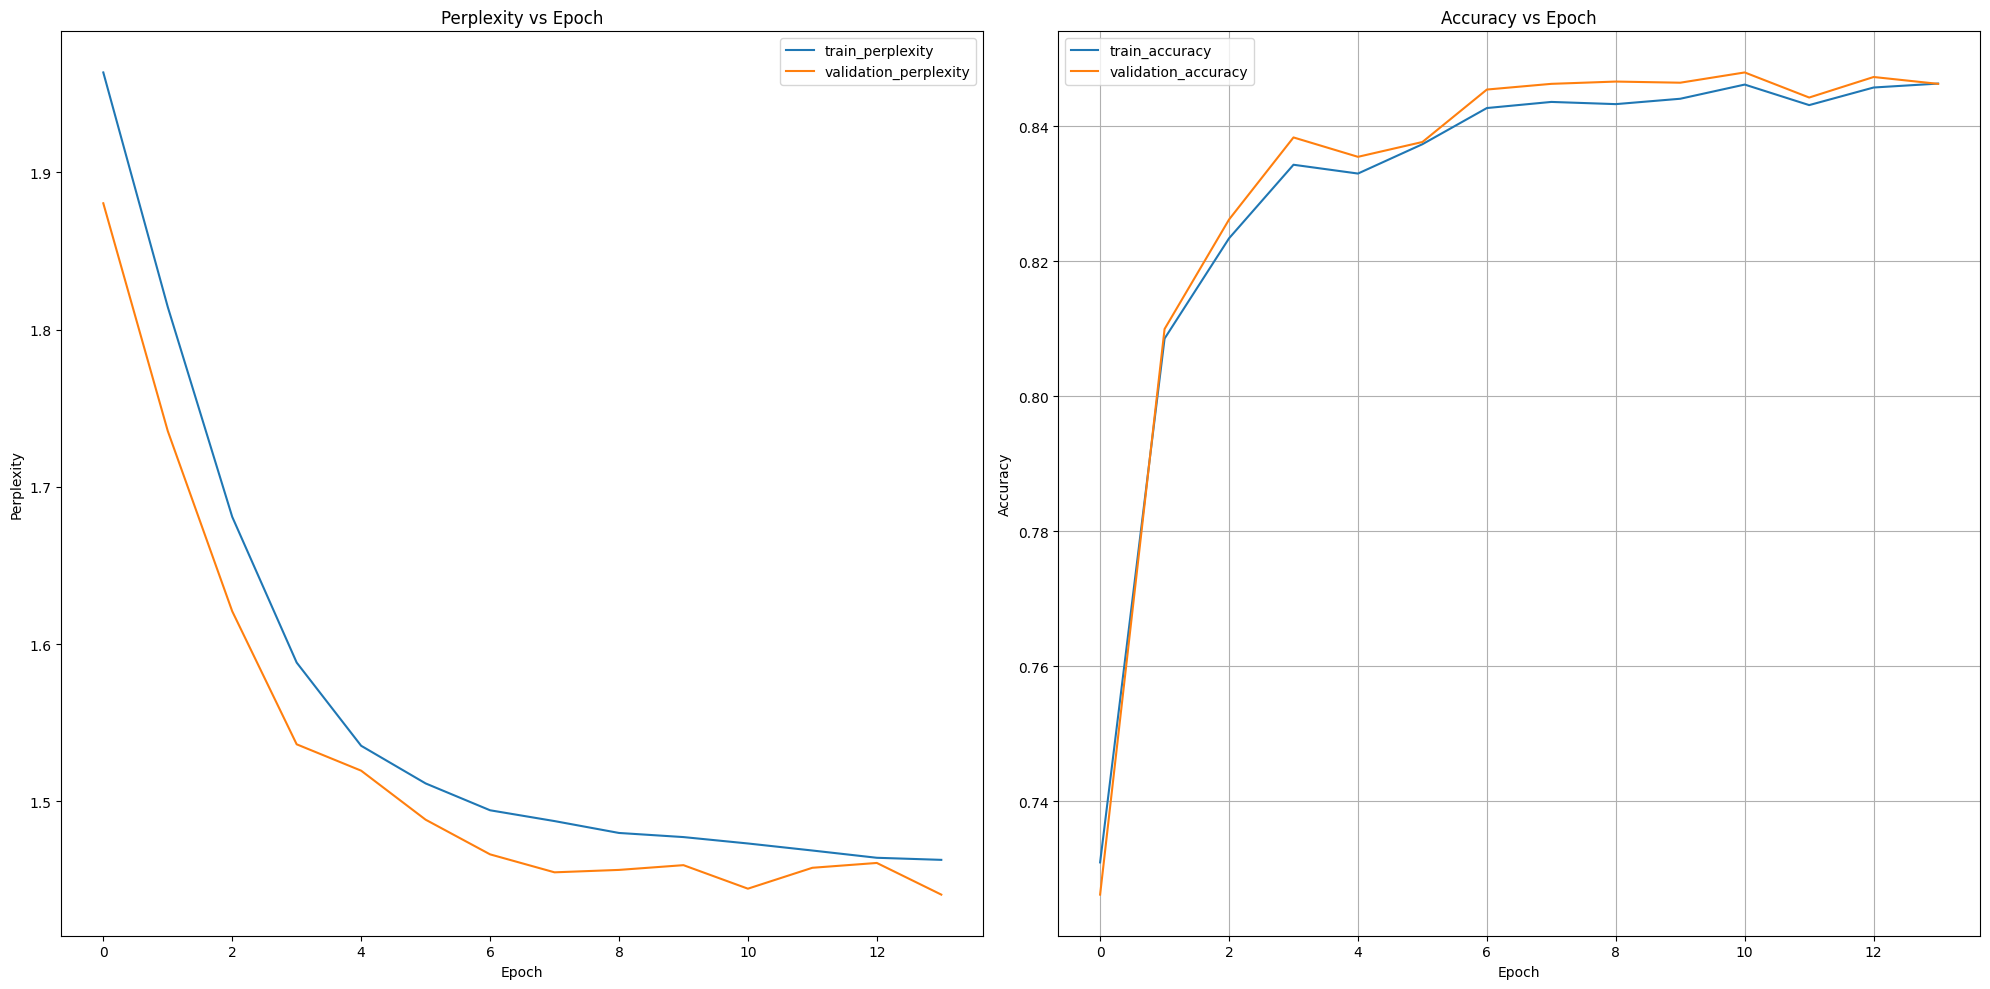

In [15]:
#from utils import evaluate, set_seed_nb, unit_test_values, deterministic_init
import matplotlib.pyplot as plt
# input size and output size
input_size = vocab_size

print(f"DEBUG: device:{device}")
# Model

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2norm)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.BCEWithLogitsLoss()
train_per = []
valid_per = []
train_acc_list = []
val_acc_list = []
lowest_loss = 10000
for epoch_idx in range(EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")

    train_loss, avg_train_loss = train(
        model, train_dataloader, optimizer, criterion, device=device)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = evaluate(
        model, val_dataloader, criterion, device=device)

    acc_train = find_accuracy(model, train_dataloader, device=device)
    acc_val = find_accuracy(model, val_dataloader, device=device)
    print("Training Loss: %.4f. Validation Loss: %.4f. " %
          (avg_train_loss, avg_val_loss))
    print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " %
          (np.exp(avg_train_loss), np.exp(avg_val_loss)))
    print("Training Acc: %.4f. Validation Acc: %.4f. " %
          (acc_train, acc_val))

    if np.exp(avg_val_loss) < lowest_loss:
        torch.save(model.state_dict(), model_path)
        lowest_loss = np.exp(avg_val_loss)
        print("Saved model")

    train_per.append(np.exp(avg_train_loss))
    valid_per.append(np.exp(avg_val_loss))

    train_acc_list.append(acc_train)
    val_acc_list.append(acc_val)

    x_dim = list(range(epoch_idx+1))

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    ax1.plot(x_dim, train_per, label='train_perplexity')
    ax1.plot(x_dim, valid_per, label='validation_perplexity')
    ax1.set_title('Perplexity vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Perplexity')
    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(x_dim, train_acc_list, label='train_accuracy')
    ax2.plot(x_dim, val_acc_list, label='validation_accuracy')
    ax2.set_title('Accuracy vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.savefig('perplexity_LSTM.png')

In [16]:
# Simply running validation step
input_size = vocab_size

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
val_loss, avg_val_loss = evaluate(
        model, val_dataloader, criterion, device=device)
acc = find_accuracy(
        model, val_dataloader, device=device)
print("Validation Loss: %.4f. " %(avg_val_loss))
print("Validation Perplexity: %.4f. " %(np.exp(avg_val_loss)))
print("Validation Accuracy: %.4f. " %(acc))

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Validation Loss: 0.3651. 
Validation Perplexity: 1.4407. 
Validation Accuracy: 0.8463. 


In [17]:
# Simply running test step
input_size = vocab_size

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)

if device == 'cuda':
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

test_loss, avg_test_loss = evaluate(
        model, test_dataloader, criterion, device=device)

acc = find_accuracy(model, test_dataloader, device=device)
print("Test Loss: %.4f. " %(avg_test_loss))
print("Test Perplexity: %.4f. " %(np.exp(avg_test_loss)))
print("Test accuracy: %.4f. " %(acc))

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Test Loss: 0.3586. 
Test Perplexity: 1.4313. 
Test accuracy: 0.8485. 
